# Data orgnization and train test split

In [2]:
import os
import pandas as pd

In [3]:

origin_image_dir = "datasets/46k66mz9sz-2/00_UAV-derived Thermal Waterfowl Dataset/00_UAV-derived Waterfowl Thermal Imagery Dataset/01_Thermal Images and Ground Truth (used for detector training and testing)/01_Posistive Image"

img_length = len(os.listdir(origin_image_dir))
print(f"Total images: {img_length}")

Total images: 355


In [4]:
labels_df = pd.read_csv("datasets/46k66mz9sz-2/00_UAV-derived Thermal Waterfowl Dataset/00_UAV-derived Waterfowl Thermal Imagery Dataset/01_Thermal Images and Ground Truth (used for detector training and testing)/02_Groundtruth Label for Positive Images/Bounding Box Label.csv")
print(f"Total labels: {len(labels_df)}")
print(labels_df.head())

Total labels: 8975
               imageFilename  x(column)  y(row)  width  height
0  20180322_101536_979_R.tif        127      11      7       7
1  20180322_101536_979_R.tif        174      32      7       7
2  20180322_101536_979_R.tif        178      19      7       7
3  20180322_101536_979_R.tif        199      31      7       7
4  20180322_101536_979_R.tif        223      51      7       7


In [5]:
img_names = labels_df['imageFilename'].unique()
print(f"Total images with labels: {len(img_names)}")
print(img_names[:5])

Total images with labels: 355
['20180322_101536_979_R.tif' '20180322_101537_980_R.tif'
 '20180322_101538_982_R.tif' '20180322_101539_982_R.tif'
 '20180322_101540_982_R.tif']


In [6]:
# split the dataset into train and test sets with 90% train and 10% val
from sklearn.model_selection import train_test_split
train_names, val_names = train_test_split(img_names, test_size=0.15, random_state=42)
print(f"Train images: {len(train_names)}")
print(f"Validation images: {len(val_names)}")


Train images: 301
Validation images: 54


In [15]:
root_data_dir = "datasets/yolo_coco"
os.makedirs(os.path.join(root_data_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(root_data_dir, "val"), exist_ok=True)
os.makedirs(os.path.join(root_data_dir, "train", "images"), exist_ok=True)
os.makedirs(os.path.join(root_data_dir, "train", "labels"), exist_ok=True)
os.makedirs(os.path.join(root_data_dir, "val", "images"), exist_ok=True)
os.makedirs(os.path.join(root_data_dir, "val", "labels"), exist_ok=True)

def convert_to_yolo_format(row, img_width, img_height):
    x_center = (row['x(column)'] + row['width'] * 0.5) / img_width
    y_center = (row['y(row)'] + row['height'] * 0.5) / img_height
    width = row['width'] / img_width
    height = row['height'] / img_height
    return f"0 {x_center} {y_center} {width} {height}"  # Assuming class '0' for waterfowl

from PIL import Image
import shutil
from tqdm import tqdm

def process_dataset(image_names, subset):
    for img_name in tqdm(image_names):
        img_path = os.path.join(origin_image_dir, img_name)
        label_rows = labels_df[labels_df['imageFilename'] == img_name]
        
        # Get image dimensions
        with Image.open(img_path) as img:
            img_width, img_height = img.size
        
        # Create label file content
        yolo_labels = []
        for _, row in label_rows.iterrows():
            yolo_label = convert_to_yolo_format(row, img_width, img_height)
            yolo_labels.append(yolo_label)
        
        # Write label file
        label_file_path = os.path.join(root_data_dir, subset, "labels", img_name.replace('.tif', '.txt'))
        with open(label_file_path, 'w') as f:
            f.write('\n'.join(yolo_labels))
        
        # Copy image to train images directory
        shutil.copy(img_path, os.path.join(root_data_dir, subset, "images", img_name))

process_dataset(train_names, "train")
process_dataset(val_names, "val")


100%|██████████| 54/54 [00:00<00:00, 838.86it/s]


# Visualize label

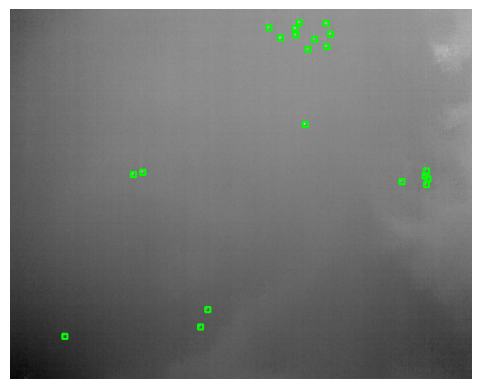

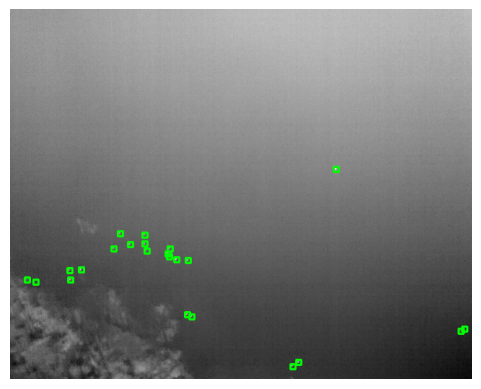

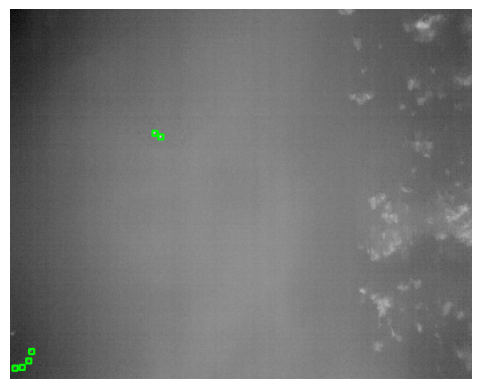

In [8]:
import matplotlib.pyplot as plt
import cv2

root_data_dir = "datasets/yolo_coco"
def visualize_sample(image_path, label_path):
    img = cv2.imread(image_path)
    height, width, _ = img.shape    
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center = float(parts[1]) * width
            y_center = float(parts[2]) * height
            box_width = float(parts[3]) * width
            box_height = float(parts[4]) * height
            
            x1 = int(x_center - box_width / 2)
            y1 = int(y_center - box_height / 2)
            x2 = int(x_center + box_width / 2)
            y2 = int(y_center + box_height / 2)
            
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

for img_name in val_names[:3]:
    image_path = os.path.join(root_data_dir, "val", "images", img_name)
    label_path = os.path.join(root_data_dir, "val", "labels", img_name.replace('.tif', '.txt'))
    visualize_sample(image_path, label_path)


